#### 1. Load the video (.tif)
user-defined variables: mvlength, crop-out images, the number of pixels interpolated between two original pixels.

In [6]:
import numpy as np
from numpy.fft import (fftshift, ifftshift, fftn, ifftn, rfftn, irfftn, fft, ifft)

In [2]:
# user-defined variables: mvlength, crop-out images, order

# fpath:
#     [string] the directory of the input file .
# fname:
#     [string] file name of the input file. It has to be a TIFF movie.
filepath = 'fIntep_forTIFF'
filename = 'Demo.tif'

# load the image 
im = imageio.imread(filepath + '/' + filename)
imarray = np.double(np.array(im))

# get dimensions and number of frames
xdim, ydim = imarray.shape
xrange, yrange = 2 * xdim, 2 * ydim    # define the ft spectrum span
#im.load()
#n_frames = im.n_frames

#### 2. Define FT and IFT matrices.
Mirror extension of each frame was performed prior to Fourier interpolation to avoid ringing artifacts. Fourier interpolation was implemented with transformation matrix operation, where the Fourier transformation matrix was constructed with the original matrix size without interpolation grids, and the inverse Fourier transformation matrix 
encodes the extra interpolation position coordinates. 

This way we create a mathematical equivalence of zero-padding fourier interpolation, but avoid actual zero-padding in the Fourier space in order to reduce the physical memory occupation for the operation. The resulting TIFF file can be applied for SOFI processing to produce fSOFI results.

In [11]:
# Set up base vectors.
#F = fftshift(fft(ifftshift(f))) # Fourier transform
#f = fftshift(ifft(ifftshift(F))) # inverse Fourier transform
xdim, ydim = 220, 100
xrange, yrange = 2 * xdim, 2 * ydim    # define the ft spectrum span
def base_vect_generator2D(xrange, yrange):
    bx, by = np.zeros(xrange), np.zeros(yrange)
    bx[1], by[1] = 1, 1
    bx, by = np.fft.fft(bx), np.fft.fft(by)
    #bx, by = fftshift(fft(ifftshift(bx))), fftshift(fft(ifftshift(by)))
    return bx, by

In [13]:
bx, by = base_vect_generator2D(xrange, yrange)
print(by[199], bx[22], bx.shape, by.shape)

(0.9995065603657315+0.03141075907812829j) (0.9510565162951536-0.3090169943749474j) (440,) (200,)


In [14]:
# Define Fourier transform metrix.
def calc_ft_matrix(base, spectrum_range):
    power_matrix = np.ones((spectrum_range, spectrum_range))
    power_matrix = np.arange(spectrum_range).reshape(spectrum_range, 1) * power_matrix
    ft_matrix = np.power(base, power_matrix)
    return ft_matrix
    
def ft_matrix2D(xrange, yrange):
    #xrange, yrange = 2 * xdim, 2 * ydim
    bx, by = base_vect_generator2D(xrange, yrange)
    
    # Fx
#     xPowerMatrix = np.ones((xrange, xrange))
#     xPowerMatrix = np.arange(xrange).reshape(xrange, 1) * xPowerMatrix
#     fx = np.power(bx, xPowerMatrix)
    fx = calc_ft_matrix(bx, xrange)

    # Fy
#     yPowerMatrix = np.ones((yrange, yrange))
#     yPowerMatrix = np.arange(yrange).reshape(yrange, 1) * yPowerMatrix
#     fy = np.power(by, yPowerMatrix).T
    fy = calc_ft_matrix(by, yrange).T
    return fx, fy

In [15]:
# example:
fx, fy = ft_matrix2D(xrange, yrange)
print(fx[1][2], fx.shape, fy.shape)

(0.9995921928281892-0.02855605079369625j) (440, 440) (200, 200)


In [16]:
# Define inverse Fourier transform metrix.
def calc_ift_matrix(base, spectrum_range, interp_num):
    conj_base = np.reshape(np.conj(base), (1, spectrum_range))
    ift = np.matmul(np.ones(((spectrum_range - 1) * interp_num + 1, 1)),conj_base)
    iftp = np.arange(0, spectrum_range - 1 + 1e-10, 1/interp_num)
    iftp = np.matmul(iftp.reshape(-1, 1), np.ones((1, spectrum_range)))
    ift = np.power(ift, iftp) / spectrum_range
    return ift
    
def ift_matrix2D(xrange, yrange, interp_num):
    '''
    xrange: int, 2 times the dimension x of a frame
    yrange: int, 2 times the dimension y of a frame
    interp_num: int, the number of times the resolution enhanced, 
        e.g. when interp_num = 2, d' = d / 2, the resolution if two times the original one.
    '''
    bx, by = base_vect_generator2D(xrange, yrange)
    
    # ifx
#     conj_bx = np.reshape(np.conj(bx), (1,xrange))
#     ifx = np.dot(np.ones(((xrange - 1) * interp_num + 1,1)),conj_bx)
#     ifxp = np.arange(0, xrange-1+1/interp_num, 1/interp_num)
#     ifxp = np.dot(ifxp.reshape(-1, 1), np.ones((1, xrange)))
#     ifx = np.power(ifx,ifxp)/xrange
    ifx = calc_ift_matrix(bx, xrange, interp_num)

    # ify
#     conj_by = np.reshape(np.conj(by), (1, yrange))
#     ify = np.dot(np.ones(((yrange - 1) * interp_num + 1,1)),conj_by)
#     ifyp = np.arange(0, yrange-1+1/interp_num, 1/interp_num)
#     ifyp = np.dot(ifyp.reshape(-1, 1), np.ones((1, yrange)))
#     ify = np.power(ify,ifyp).T/yrange
    ify = calc_ift_matrix(by, yrange, interp_num).T
    
    return ifx, ify

In [18]:
# example
interp_num = 2
ifx, ify = ift_matrix2D(xrange, yrange, interp_num)
print(ifx[10][1],ifx.shape,ify.shape)

(0.0022669366241142123+0.00016213450727098252j) (879, 440) (200, 399)


#### 3. Carry out Fourier interpolation on each frame.

In [26]:
def interpolate_image(im, fx, fy, ifx, ify, xdim, ydim, interp_num):
    # [im,fliplr(im);flipud(im),rot90(im,2)] is mirror-extension of the image A to create the natural peoriocity in the resulting image to avoid ringing artifacts after fourier interpolation.
    ext_im = np.append(np.append(im, np.fliplr(im), axis=1), 
                       np.append(np.flipud(im), np.rot90(im, 2), axis=1), axis=0)

    # Fourier transform
    fall = np.matmul(np.matmul(fx, ext_im), fy)     # fall=fx@ext_im@fy for Python 3.5 or newer versions

    # Inverse Fourier transform
    ifall = np.absolute(np.dot(np.dot(ifx, fall),ify))

    # Take the region corresponding to the FOV of the original image
    xdim_new = (xdim - 1) * interp_num + 1
    ydim_new = (ydim - 1) * interp_num + 1
    interp_im = ifall[:xdim_new, :ydim_new]
    
    return interp_im


In [122]:
def fourier_interp_tiffimage(im, interp_num_lst):
    # get dimensions and number of frames
    xdim, ydim = im.shape
    xrange, yrange = 2 * xdim, 2 * ydim    # define the ft spectrum span
    fx, fy = ft_matrix2D(xrange, yrange)
    interp_im_lst = []
    for interp_num in interp_num_lst:
        ifx, ify = ift_matrix2D(xrange, yrange, interp_num)
        interp_im = interpolate_image(im, fx, fy, ifx, ify, xdim, ydim, interp_num)       
        interp_im_lst.append(np.int_(np.around(interp_im)))
            
    return interp_im_lst

In [124]:
finalinterp_im_lst = fourier_interp_tiffimage(im, interp_num_lst)

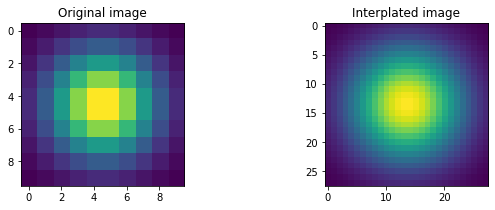

In [29]:
# simple example for interpolate_image(im, fx, fy, ifx, ify, xdim, ydim, interp_num) function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
xdim, ydim, sigma, mu = 10, 10, 0.5, 0
x, y = np.meshgrid(np.linspace(-1,1,xdim), np.linspace(-1,1,xdim))
im = np.exp(-((np.sqrt(x*x + y*y) - mu)**2 / (2*sigma**2)))
xrange, yrange, interp_num = 2 * xdim, 2 * ydim, 3
fx, fy = ft_matrix2D(xrange, yrange)
ifx, ify = ift_matrix2D(xrange, yrange, interp_num)
interp_im = interpolate_image(im, fx, fy, ifx, ify, xdim, ydim, interp_num)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].set_title('Original image')
axs[0].imshow(im)
axs[1].set_title('Interplated image')
axs[1].imshow(interp_im)

In [107]:
# example
filepath = 'fIntep_forTIFF'
filename = 'Demo.tif'

# load the image 
im = imageio.imread(filepath + '/' + filename)
im = np.float16(np.array(im))
interp_num_lst = [2, 3]
finalinterp_im_lst = fourier_interp_tiffimage(im, interp_num_lst, save_option = False)

1
2


In [99]:
im.dtype

dtype('float16')

In [118]:
np.shape(finalinterp_im_lst[1])

(298, 658)

In [177]:
def fourier_interp_tiffstack(filepath, filename, interp_num_lst, mvlength = None, save_option = True, return_option = False):

    imstack = tiff.TiffFile(filepath + '/' + filename + '.tif')
    xdim, ydim = np.shape(imstack.pages[0])
    xrange, yrange = 2 * xdim, 2 * ydim
    fx, fy = ft_matrix2D(xrange, yrange)
    interp_imstack_lst = []
    
    # if user did not select the video length, process on the whole video
    if mvlength == None:
        mvlength = len(imstack.pages)
        
    for interp_num in interp_num_lst:
        ifx, ify = ift_matrix2D(xrange, yrange, interp_num)
        interp_imstack = []

        for frame in range(mvlength):
            im = tiff.imread(filepath + '/' + filename + '.tif', key=frame)
            interp_im = interpolate_image(im, fx, fy, ifx, ify, xdim, ydim, interp_num)
            interp_im = np.int_(np.around(interp_im))
            if save_option == True:
                tiff.imwrite(filename + '_InterpNum' + str(interp_num) + '.tif', interp_im, dtype='int', append=True)
            if return_option == True:
                interp_imstack.append(interp_im)
                
        if return_option == True:  
            interp_imstack_lst.append(interp_imstack) 
    
    if return_option == True:
        return interp_imstack_lst

In [176]:
import tifffile as tiff
filepath = 'SampleData'
filename = 'Block1'
fourier_interp_tiffstack(filepath, filename, [4], mvlength = 20, return_option = False)

In [138]:
def fourier_interp_tiffstack_oldversion(filepath, filename, interp_num_lst, mvlength = None, save_option = True, return_option = False):

    imstack = imageio.mimread(filepath + '/' + filename + '.tif')
    xdim, ydim = np.shape(imstack[0])
    xrange, yrange = 2 * xdim, 2 * ydim
    fx, fy = ft_matrix2D(xrange, yrange)
    interp_imstack_lst = []
    
    # if user did not select the video length, process on the whole video
    if mvlength == None:
        mvlength = len(imstack)
        
    for interp_num in interp_num_lst:
        ifx, ify = ift_matrix2D(xrange, yrange, interp_num)
        interp_imstack = []
        frame_num = 0
        for im in imstack:
            frame_num = frame_num + 1
            interp_im = interpolate_image(im, fx, fy, ifx, ify, xdim, ydim, interp_num)
            interp_imstack.append(interp_im)
            
            if frame_num >= mvlength:
                break
            
        if save_option == True:
            #imageio.mimwrite(filename + '_InterpNum' + str(interp_num) + '.tif', np.int16(interp_imstack))
            imageio.mimwrite(filename + '_InterpNum' + str(interp_num) + '.tif', np.int16(np.around(interp_imstack)))
            
        interp_imstack_lst.append(np.int_(np.around(interp_imstack)))  
    
    if return_option == True:
        return interp_imstack_lst
            

In [49]:
filepath = 'fIntep_forTIFF'
filename = 'Demo'

# load the image 
im = imageio.imread(filepath + '/' + filename + '.tif')

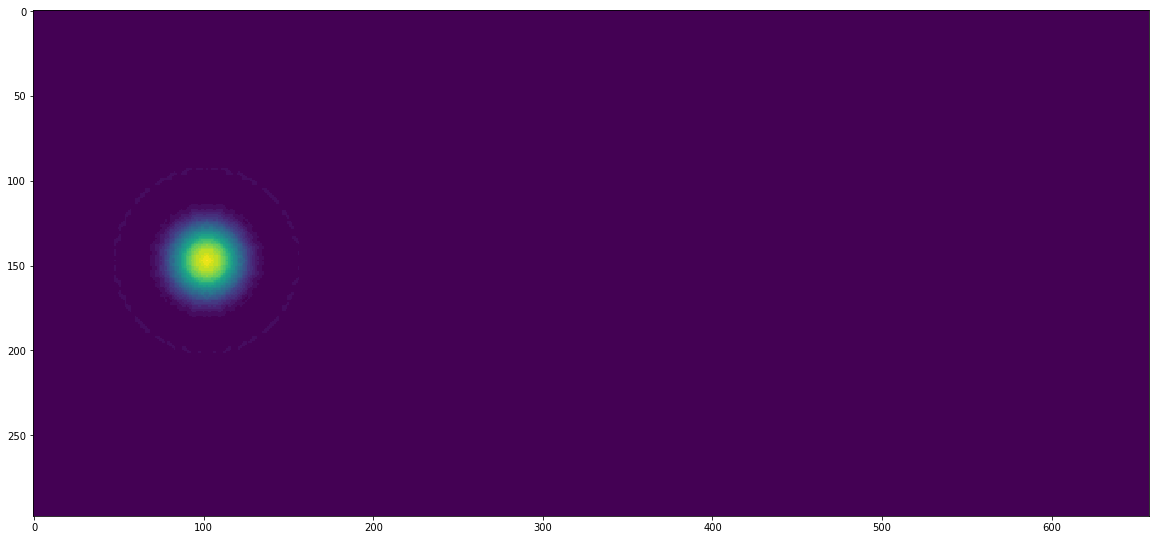

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(t[1][0])

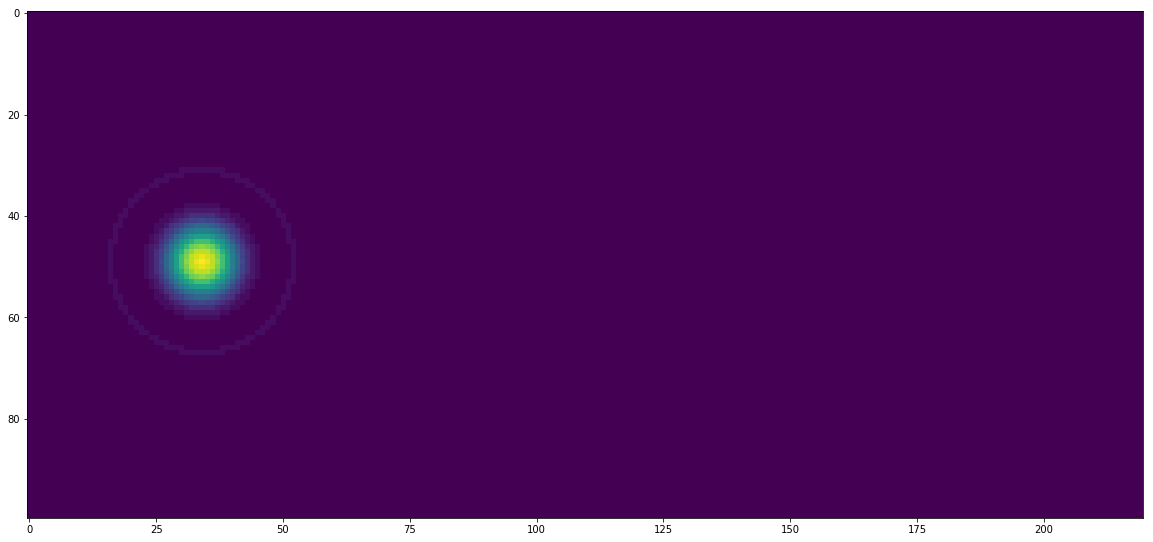

In [59]:
plt.figure(figsize=(20,10))
plt.imshow(im)

In [58]:
t[0][20][160,120]

0